In [17]:
#IMPORTS
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import joblib
load_dotenv()
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


Como os dados já foram limpos e salvos em um csv, irie utilizar os dados deste csv à partir de certa data para a previsão dos novos dados. Apenas para não ter que refazer toda a limpeza que já foi feita antes

In [12]:
df = pd.read_csv('../data/dados_limpos.csv')
data_limite = pd.to_datetime("2024-08-31")
df['date'] = pd.to_datetime(df['date'])
df_treino = df[df['date'] > data_limite].copy()

In [14]:
df = df_treino.sort_values(by='date', ascending=True)
df.head()

,appId,date,monthly_active_users,country,lang,predictionLoss,newinstalls,category,total_ratings,daily_ratings,reviews,daily_reviews,daily_active_users_TARGET
26058,com.app.36257,2024-09-01,2252258.0,br,pt,7905.0,6291.0,BUSINESS,110643.0,46.0,64876.0,27.0,651372.0
37324,com.app.33540,2024-09-01,3511820.0,br,pt,28286.0,5558.0,FINANCE,383889.0,270.0,90147.0,17.0,452491.0
9454,com.app.48916,2024-09-01,15587.0,br,pt,811.0,244.0,BUSINESS,624.0,1.0,233.0,2.0,791.0
9455,com.app.96897,2024-09-01,502367.0,br,pt,4094.0,780.0,FINANCE,14739.0,12.0,7088.0,5.0,44680.0
34788,com.app.44002,2024-09-01,147989.0,br,pt,4468.0,226.0,TRAVEL_AND_LOCAL,11358.0,13.0,3726.0,2.0,14592.0


- Criando variáveis adicionais (essas variáveis também podem ser criadas diretamente na query SQL)

In [18]:
df['daily_ratings_ultimos_30_dias'] = (df.groupby('appId')['daily_ratings'].rolling(window=30, min_periods=1).sum().reset_index(level=0, drop=True))
df['predictionLoss_ultimos_30_dias'] = (df.groupby('appId')['predictionLoss'].rolling(window=30, min_periods=1).sum().reset_index(level=0, drop=True))
df['delta_ratings'] = df['daily_ratings'] / df['total_ratings']
df['reviews_ultimos_30_dias'] = (df.groupby('appId')['reviews'].rolling(window=30, min_periods=1).sum().reset_index(level=0, drop=True))



#2. Carregar modelo e colunas
modelo = joblib.load("../models/melhor_modelo_rf.joblib")
colunas_treinadas = joblib.load("../models/colunas_treinadas.joblib")
df['date'] = pd.to_datetime(df['date'])

#Usar as mesmas colunas usadas no treinamento
X_novos = df[colunas_treinadas].copy()

#Aplicar previsões
y_pred_log = modelo.predict(X_novos)
y_pred = np.expm1(y_pred_log)  # Volta ao formato original

#pegando dados do y_real, gravando y_predito e gerando uma coluna de erro
df['DAU_real'] = df['daily_active_users_TARGET']
df['DAU_previsto'] = y_pred
df['erro_absoluto'] = abs(df['DAU_real'] - df['DAU_previsto'])

#Calcular métricas
mae = mean_absolute_error(df['DAU_real'], df['DAU_previsto'])
rmse = np.sqrt(mean_squared_error(df['DAU_real'], df['DAU_previsto']))
r2 = r2_score(df['DAU_real'], df['DAU_previsto'])

print(f"📊 Avaliação no novo conjunto:")
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²:   {r2:.4f}")

#Final
df_resultado = df[['date', 'appId', 'DAU_real', 'DAU_previsto', 'erro_absoluto']]
display(df_resultado.head())

📊 Avaliação no novo conjunto:
MAE:  107,534.96
RMSE: 324,152.47
R²:   0.9462


,date,appId,DAU_real,DAU_previsto,erro_absoluto
26058,2024-09-01,com.app.36257,651372.0,481901.061968,169470.938032
37324,2024-09-01,com.app.33540,452491.0,481901.061968,29410.061968
9454,2024-09-01,com.app.48916,791.0,1224.293413,433.293413
9455,2024-09-01,com.app.96897,44680.0,96156.384553,51476.384553
34788,2024-09-01,com.app.44002,14592.0,9036.219874,5555.780126


C:\Users\ACER\AppData\Local\Temp\ipykernel_7856\1429818065.py:11: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\tudo\Adenis\rankmyapp_case_senior_data_scientist\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


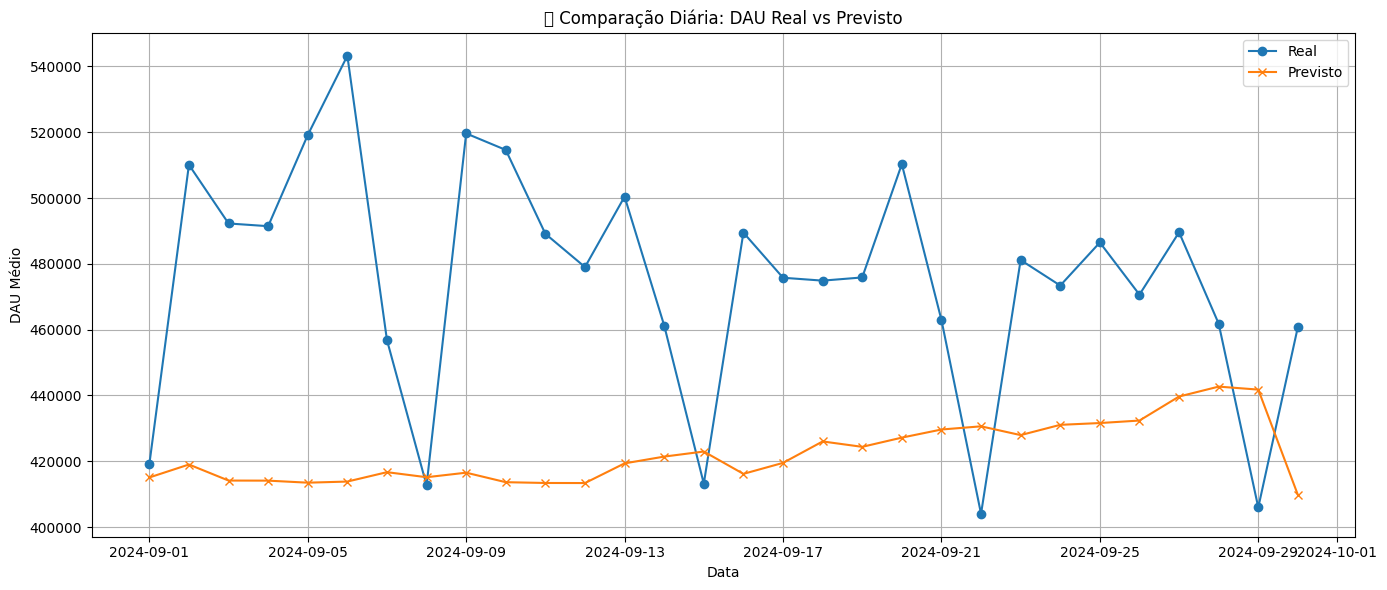

In [20]:
df_dia = df_resultado.groupby('date')[['DAU_real', 'DAU_previsto']].mean()

plt.figure(figsize=(14, 6))
plt.plot(df_dia.index, df_dia['DAU_real'], label='Real', marker='o')
plt.plot(df_dia.index, df_dia['DAU_previsto'], label='Previsto', marker='x')
plt.title("📅 Comparação Diária: DAU Real vs Previsto")
plt.xlabel("Data")
plt.ylabel("DAU Médio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- O gráfico mostra claramente uma diferença entre os valores reais e previstos para DAU, principalmente nos picos e quedas abruptas de acessos. Isso acontece quando existe uma alta variabilidade nos dados e picos sazonais, mas o modelo ainda não conseguiu captar bem essas nuances. <br><br>
- No entanto, as métricas MAE, RMSE e R² indicam uma performance melhor no geral, do que a apresentada no gráfico.
    - MAE ~ 107 mil em um volume de DAU médio de ~400 a 500 mil → erro absoluto de ~20–25%.<br>
    - RMSE ~ 324 mil mostra que há erros maiores em alguns dias (picos).<br>
    - R² = 0.9462 → o modelo está explicando mais de 94% da variância, o que é muito bom.<br>

INTERPRETAÇÃO

- O modelo generaliza bem a tendência geral, visto que a linha laranja segue um movimento suave e não previsões totalmente discrepantes entre si.<br><br>
- Pontos de falha: o modelo não acompanha oscilações abruptas de um dia para o outro.<br><br>
- Boas métricas e um gráfico que apresenta maus resultados geralmente acontecem quando o modelo acerta bem a média geral (boa performance global), mas erra em picos extremos (impactando menos o R², mas visível no gráfico).<br><br>

SUGESTÕES DE MELHORIA:
- Adicionar variáveis temporais (dia da semana, início do mês, feriado etc): a variável inicio de mês até foi criada, mas não foi utilizada no modelo final pelo fato de não ter sido relevante de acordo com a aplicação do Feature Importances.<br>

- Usar médias móveis como features auxiliares.<br>

- Realizar uma clusterização para agrupar aplicativos com comportamento semelhante e para cada cluster, treinar um modelo diferente, garantindo assim, comportamentos mais semelhantes dentro da mesma base